In [4]:
%matplotlib inline

import pandas as pd
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
import copy
import pulp
from pylab import figure, scatter, show
import networkx as nx
import pylab

In [5]:
shp_path = 'data/tl_2016_49_tract.shp'
attr_path = 'data/UT_asu_exampleData.csv'

In [6]:
qW = ps.queen_from_shapefile(shp_path)
dataframe = ps.pdio.read_files(shp_path)

In [7]:
#threshold = 0.065
threshold = 0.0649

# Visualization

In [8]:
centroids = np.array([list(poly.centroid) for poly in dataframe.geometry])

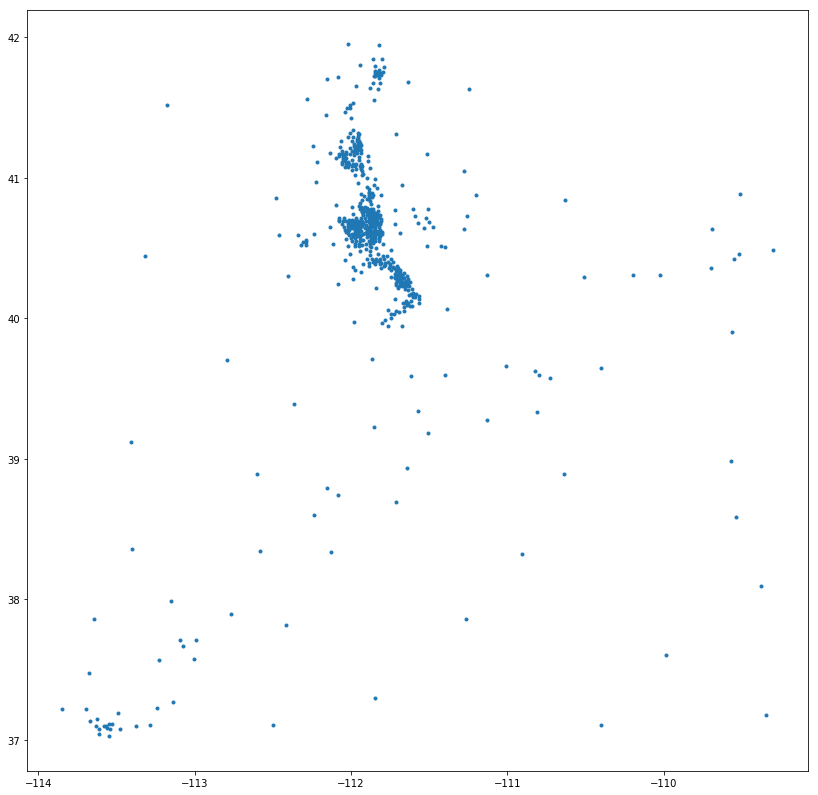

In [9]:
fig = figure(figsize=(14,14))
plt.plot(centroids[:,0], centroids[:,1],'.')
show()

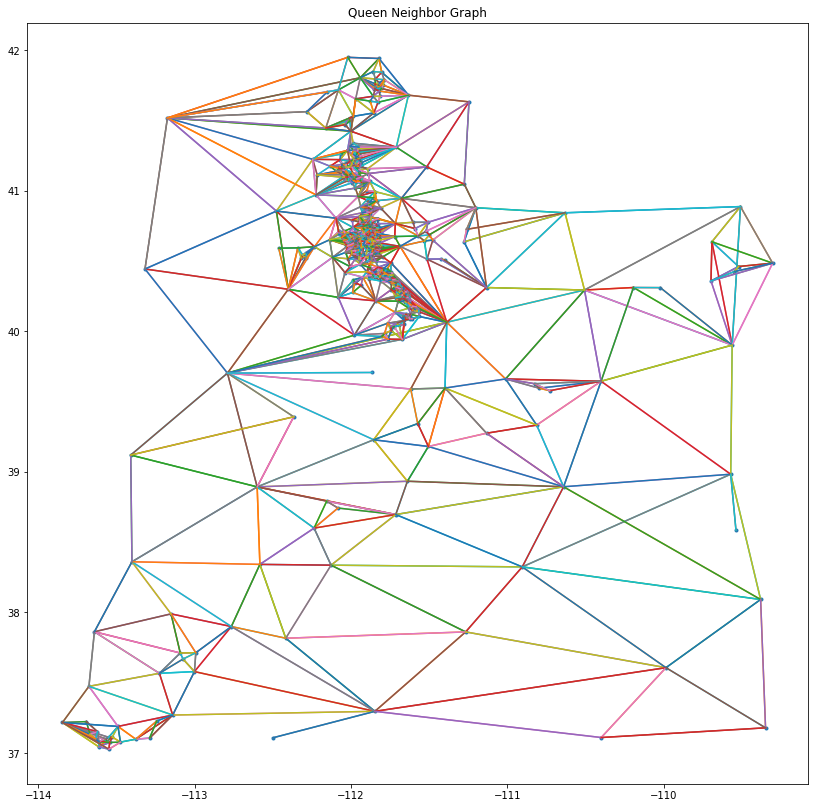

In [10]:
fig = figure(figsize=(14,14))

plt.plot(centroids[:,0], centroids[:,1],'.')

for k,neighs in qW.neighbors.items():
    #print(k,neighs)
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment[:,0], segment[:,1], '-')
plt.title('Queen Neighbor Graph')
show()

# Dateframe Prep

In [11]:
df=pd.read_csv(attr_path,dtype={'geoid': str})
df.drop(['record', 'st_fips', 'cnty_fips', 'tract_fips', 'name'], axis=1, inplace=True)

cols = ['pop', 'emp']
df[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
df['sum'] = df['unemp'] + df['emp']
df['ur'] = df['unemp']/(df['unemp'] + df['emp'])
df.loc[df['sum'] == 0, 'ur'] = 0
df.columns = map(str.upper, df.columns)

mdf=pd.merge(dataframe, df, on="GEOID")
mdf

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,POP,EMP,UNEMP,SUM,UR
0,49,057,210900,49057210900,2109,Census Tract 2109,G5020,S,4510195,0,+41.1749485,-111.9586830,<pysal.cg.shapes.Polygon object at 0x11b0b8fd0>,6813,3638,77,3715,0.020727
1,49,045,131200,49045131200,1312,Census Tract 1312,G5020,S,3255229,0,+40.5232166,-112.2901017,<pysal.cg.shapes.Polygon object at 0x11b0c9080>,3515,1393,75,1468,0.051090
2,49,045,131100,49045131100,1311,Census Tract 1311,G5020,S,7872778,0,+40.5217866,-112.3183377,<pysal.cg.shapes.Polygon object at 0x11b0c90f0>,7987,4053,205,4258,0.048145
3,49,045,130600,49045130600,1306,Census Tract 1306,G5020,S,14822474478,158583552,+40.5016499,-113.5949635,<pysal.cg.shapes.Polygon object at 0x11b0c9160>,2704,1241,37,1278,0.028951
4,49,045,130900,49045130900,1309,Census Tract 1309,G5020,S,4084749,0,+40.5435849,-112.3086306,<pysal.cg.shapes.Polygon object at 0x11b0c91d0>,4866,2113,61,2174,0.028059
5,49,045,130800,49045130800,1308,Census Tract 1308,G5020,S,26224140,230014,+40.5885593,-112.4599325,<pysal.cg.shapes.Polygon object at 0x11b0c9240>,5738,2414,128,2542,0.050354
6,49,035,101500,49035101500,1015,Census Tract 1015,G5020,S,824035,0,+40.7650072,-111.8574020,<pysal.cg.shapes.Polygon object at 0x11b0c92b0>,3582,2245,52,2297,0.022638
7,49,035,101600,49035101600,1016,Census Tract 1016,G5020,S,994220,0,+40.7553857,-111.8575658,<pysal.cg.shapes.Polygon object at 0x11b0c9320>,3768,3032,67,3099,0.021620
8,49,035,101700,49035101700,1017,Census Tract 1017,G5020,S,701146,0,+40.7650052,-111.8667584,<pysal.cg.shapes.Polygon object at 0x11b0c9390>,3668,2739,48,2787,0.017223
9,49,035,101800,49035101800,1018,Census Tract 1018,G5020,S,876270,0,+40.7551991,-111.8667596,<pysal.cg.shapes.Polygon object at 0x11b0c9400>,3459,2551,108,2659,0.040617


# Finding Seeds

In [12]:
asu_seeds = mdf.loc[mdf['UR'] >= threshold] # find rows whose ur >= 0.065
asu_seeds=asu_seeds.index.tolist()

queens = {} # a sub-dictionary of w_queen.neighbors, this sub-dict only contains asu's queens
for seed in asu_seeds:
    queens[seed]=list(set(qW.neighbors[seed]) & set(asu_seeds))
    
graph=queens
clusters=[]
visited=[]
path=[]
for i in graph:
    if i not in visited:
        q=[i]
        path=[]
        while q:
            v = q.pop()
            if v not in path:
                path += [v]
                q += graph[v]
        visited.extend(path)        
        clusters.append(path)

clusters

[[18, 572, 21, 461, 540],
 [25],
 [45, 133, 132, 530],
 [63],
 [68, 245, 164, 505, 152],
 [77],
 [80, 512, 131],
 [91],
 [110],
 [113],
 [114],
 [120, 122],
 [147],
 [187],
 [202, 517],
 [218],
 [233],
 [289],
 [355],
 [407],
 [443],
 [445],
 [453],
 [457]]

In [13]:
adf=mdf.loc[clusters[0]]
geoid = adf['GEOID'].tolist()
geoid

['49047968401', '49047968200', '49047940201', '49013940300', '49043964203']

# Region Prep

In [14]:
radius = 6
seed = clusters[0]

def gen_region(radius,seed):
    regions={}
    regions[0] = seed
    rings={}
    rings[0] = seed
    
    for i in range(1, radius+1):
        neigh = []
        donut = rings[i-1]
        for j in donut:
            neigh.extend(qW.neighbors[j])
        neigh=list(set(neigh))
        donut=[fruit for fruit in neigh if fruit not in regions[i-1]]
        rings[i] = donut
        region=[]
        region.extend(regions[i-1])
        region.extend(donut)
        regions[i]= region
    return regions,rings

regions,rings=gen_region(radius,seed)


/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


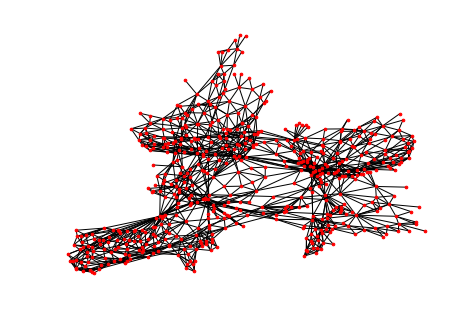

In [15]:
region = regions[radius]
region_dict = {}
for i in region:
    region_dict[i] = qW.neighbors[i]
G = nx.Graph(region_dict)
pos=nx.spring_layout(G)
nx.draw(G,pos,node_size=7)
 

In [16]:
G.nodes()

[18,
 572,
 21,
 461,
 540,
 541,
 579,
 230,
 232,
 204,
 462,
 79,
 17,
 19,
 20,
 146,
 88,
 542,
 543,
 264,
 398,
 147,
 148,
 149,
 280,
 544,
 546,
 548,
 551,
 552,
 300,
 50,
 53,
 54,
 55,
 56,
 571,
 576,
 69,
 582,
 581,
 328,
 73,
 77,
 333,
 80,
 214,
 217,
 224,
 225,
 226,
 98,
 228,
 229,
 231,
 233,
 121,
 512,
 3,
 12,
 16,
 545,
 547,
 549,
 550,
 52,
 573,
 575,
 583,
 72,
 71,
 76,
 70,
 82,
 97,
 105,
 119,
 122,
 128,
 191,
 192,
 193,
 198,
 199,
 215,
 216,
 218,
 222,
 227,
 234,
 251,
 252,
 254,
 256,
 265,
 266,
 267,
 273,
 274,
 276,
 277,
 281,
 282,
 287,
 288,
 290,
 299,
 301,
 302,
 318,
 319,
 329,
 330,
 331,
 334,
 339,
 354,
 388,
 391,
 397,
 400,
 403,
 405,
 411,
 413,
 421,
 443,
 447,
 448,
 449,
 474,
 475,
 476,
 1,
 2,
 4,
 5,
 514,
 521,
 13,
 14,
 15,
 527,
 47,
 58,
 60,
 577,
 578,
 67,
 74,
 83,
 84,
 87,
 89,
 95,
 111,
 120,
 127,
 129,
 131,
 153,
 157,
 171,
 188,
 189,
 190,
 200,
 203,
 207,
 208,
 220,
 221,
 223,
 249,
 250,

In [17]:
mdf.loc[region]

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,POP,EMP,UNEMP,SUM,UR
18,49,047,968401,49047968401,9684.01,Census Tract 9684.01,G5020,S,7514110,0,+40.4609891,-109.5200278,<pysal.cg.shapes.Polygon object at 0x11b0c97f0>,4414,1546,342,1888,0.181144
572,49,047,968200,49047968200,9682,Census Tract 9682,G5020,S,2616861776,17423672,+40.4746357,-109.2507541,<pysal.cg.shapes.Polygon object at 0x1195cae80>,8414,3020,263,3283,0.080110
21,49,047,940201,49047940201,9402.01,Census Tract 9402.01,G5020,S,7470717156,30992577,+39.8969114,-109.5547738,<pysal.cg.shapes.Polygon object at 0x11b0c9940>,6779,1679,146,1825,0.080000
461,49,013,940300,49013940300,9403,Census Tract 9403,G5020,S,6263956404,32835394,+40.2646720,-110.5791503,<pysal.cg.shapes.Polygon object at 0x118e31d30>,4120,1477,243,1720,0.141279
540,49,043,964203,49043964203,9642.03,Census Tract 9642.03,G5020,S,2394381920,14423900,+40.8571955,-110.4849425,<pysal.cg.shapes.Polygon object at 0x1195ca080>,117,68,19,87,0.218391
541,49,043,964201,49043964201,9642.01,Census Tract 9642.01,G5020,S,182677287,24484,+40.6346198,-111.2767768,<pysal.cg.shapes.Polygon object at 0x1195ca0f0>,4006,2033,70,2103,0.033286
579,49,049,010900,49049010900,109,Census Tract 109,G5020,S,2393995088,448739,+40.0668653,-111.3869803,<pysal.cg.shapes.Polygon object at 0x11a1911d0>,1186,582,11,593,0.018550
230,49,051,940500,49051940500,9405,Census Tract 9405,G5020,S,2761331157,68631713,+40.2883266,-111.1210748,<pysal.cg.shapes.Polygon object at 0x11d528668>,10669,5307,175,5482,0.031923
232,49,013,940600,49013940600,9406,Census Tract 9406,G5020,S,2044710679,5911382,+40.3097114,-110.1762206,<pysal.cg.shapes.Polygon object at 0x11d528748>,7831,2488,142,2630,0.053992
204,49,019,000300,49019000300,3,Census Tract 3,G5020,S,9476932989,29873769,+38.9743261,-109.5734502,<pysal.cg.shapes.Polygon object at 0x11c5b0a90>,5162,2756,46,2802,0.016417


In [18]:
mdf.iloc[114]

STATEFP                                                  49
COUNTYFP                                                021
TRACTCE                                              110400
GEOID                                           49021110400
NAME                                                   1104
NAMELSAD                                  Census Tract 1104
MTFCC                                                 G5020
FUNCSTAT                                                  S
ALAND                                               3025416
AWATER                                                    0
INTPTLAT                                        +37.6687850
INTPTLON                                       -113.0743207
geometry    <pysal.cg.shapes.Polygon object at 0x11aeb82b0>
POP                                                    5110
EMP                                                    2139
UNEMP                                                   203
SUM                                     

In [19]:
#for path in nx.all_simple_paths(G, source=45, target=46):
#    print(path)

# Previous Order Neighbors

In [20]:
#given an order, create a dictionary for its previous order neighborhood (around a seed set)
#where key is each area in the given order, value is its previous order queen neighbors
#it is used to create contiguous constraints, will be called many times as needed
def gen_prev_order(cur_order):
    prev_neigh = {}
    for i in rings[cur_order]:
        prev_neigh[i] = set(qW.neighbors[i]) & set(rings[cur_order-1])
    return prev_neigh
#gen_prev_order(radius)

# Linear Programming

In [21]:
#######################################################
############ 1. create the model ######################
#######################################################
my_lp_problem = pulp.LpProblem("My LP Problem", pulp.LpMaximize)    

In [22]:
#######################################################
############ 2. create decision variables #############
#######################################################
decision_variables ={}
for i in region:
    variablestr = str('x' + str(i))
    variable = pulp.LpVariable(str(variablestr), lowBound = 0, upBound = 1, cat= 'Integer')
    decision_variables[i] = variable

In [23]:
#######################################################
############ 3. create objective function #############
#######################################################
total_pop = ""

for key, value in decision_variables.items():
    for rownum, row in mdf.iterrows():
        if key == rownum:
            total_pop += row['POP']*value
            
my_lp_problem += total_pop
print ("Optimization function: "+str(total_pop))

Optimization function: 6813*x0 + 3515*x1 + 2576*x10 + 4619*x104 + 1591*x105 + 4560*x106 + 7341*x107 + 3715*x108 + 5155*x109 + 5665*x111 + 6366*x112 + 8124*x113 + 5110*x114 + 3972*x115 + 9795*x116 + 3611*x117 + 5930*x118 + 5475*x119 + 4532*x12 + 2391*x120 + 4212*x121 + 4154*x122 + 4500*x123 + 5717*x125 + 5524*x126 + 5261*x127 + 6406*x128 + 4321*x129 + 3607*x13 + 2324*x131 + 4845*x136 + 4780*x137 + 4522*x138 + 2956*x139 + 4917*x14 + 2876*x140 + 2456*x141 + 4139*x142 + 3673*x145 + 3952*x146 + 4433*x147 + 3595*x148 + 4213*x149 + 5171*x15 + 3452*x150 + 4485*x151 + 1476*x152 + 7159*x153 + 4308*x154 + 3913*x155 + 4247*x156 + 4670*x157 + 7024*x158 + 2782*x16 + 3230*x161 + 5055*x162 + 3196*x165 + 4251*x166 + 4741*x169 + 5483*x17 + 5276*x170 + 108*x171 + 7422*x172 + 8249*x173 + 1673*x174 + 3358*x175 + 4644*x177 + 4861*x178 + 4965*x179 + 4414*x18 + 3702*x180 + 2159*x181 + 6842*x182 + 5896*x183 + 6270*x184 + 3669*x185 + 3373*x186 + 3031*x187 + 3458*x188 + 4959*x189 + 6105*x19 + 6408*x190 + 3008*x1

In [24]:
#################################################
############ 4. create constraints ##############
#################################################

########### 4.1 create constraint such that the seeds should be included.
for i in seed:
    my_lp_problem += (decision_variables[i] == 1)

#my_lp_problem += (decision_variables[114] ==1)  
########## 4.2 create constraint such that ur is no less than the threshold.
nume = ""
denomi = ""
for key, value in decision_variables.items():
    for rownum, row in mdf.iterrows():
        if key == rownum:
            nume += row['UNEMP']*value
            denomi += (row['UNEMP']+row['EMP'])*value

my_lp_problem += (nume >= threshold*denomi)

########## 4.3 create constraint such that the region is contiguous.
for i in range(1,radius+1):
    prev=gen_prev_order(i)
    for j in prev: # key of the dict
        self_var = decision_variables[j]
        neigh = ""
        for va in prev[j]: #for each value of the key
            neigh += decision_variables[va]
        my_lp_problem += (self_var <= neigh)
    
my_lp_problem  

My LP Problem:
MAXIMIZE
6813*x0 + 3515*x1 + 2576*x10 + 4619*x104 + 1591*x105 + 4560*x106 + 7341*x107 + 3715*x108 + 5155*x109 + 5665*x111 + 6366*x112 + 8124*x113 + 5110*x114 + 3972*x115 + 9795*x116 + 3611*x117 + 5930*x118 + 5475*x119 + 4532*x12 + 2391*x120 + 4212*x121 + 4154*x122 + 4500*x123 + 5717*x125 + 5524*x126 + 5261*x127 + 6406*x128 + 4321*x129 + 3607*x13 + 2324*x131 + 4845*x136 + 4780*x137 + 4522*x138 + 2956*x139 + 4917*x14 + 2876*x140 + 2456*x141 + 4139*x142 + 3673*x145 + 3952*x146 + 4433*x147 + 3595*x148 + 4213*x149 + 5171*x15 + 3452*x150 + 4485*x151 + 1476*x152 + 7159*x153 + 4308*x154 + 3913*x155 + 4247*x156 + 4670*x157 + 7024*x158 + 2782*x16 + 3230*x161 + 5055*x162 + 3196*x165 + 4251*x166 + 4741*x169 + 5483*x17 + 5276*x170 + 108*x171 + 7422*x172 + 8249*x173 + 1673*x174 + 3358*x175 + 4644*x177 + 4861*x178 + 4965*x179 + 4414*x18 + 3702*x180 + 2159*x181 + 6842*x182 + 5896*x183 + 6270*x184 + 3669*x185 + 3373*x186 + 3031*x187 + 3458*x188 + 4959*x189 + 6105*x19 + 6408*x190 + 3008*x

In [25]:
###########################################
############ 5. run optimization ##########
###########################################

optimization_result = my_lp_problem.solve()
assert optimization_result == pulp.LpStatusOptimal
print("Status:", pulp.LpStatus[my_lp_problem.status])
print("Optimal Solution to the problem: ", pulp.value(my_lp_problem.objective))
print ("Individual decision_variables: ")
for v in my_lp_problem.variables():
    print(v.name, "=", v.varValue)

Status: Optimal
Optimal Solution to the problem:  197173.0
Individual decision_variables: 
x0 = 0.0
x1 = 0.0
x10 = 0.0
x104 = 0.0
x105 = 1.0
x106 = 0.0
x107 = 0.0
x108 = 0.0
x109 = 0.0
x111 = 0.0
x112 = 0.0
x113 = 0.0
x114 = 0.0
x115 = 1.0
x116 = 0.0
x117 = 0.0
x118 = 0.0
x119 = 0.0
x12 = 0.0
x120 = 1.0
x121 = 1.0
x122 = 1.0
x123 = 0.0
x125 = 0.0
x126 = 0.0
x127 = 0.0
x128 = 0.0
x129 = 0.0
x13 = 0.0
x131 = 1.0
x136 = 0.0
x137 = 0.0
x138 = 0.0
x139 = 0.0
x14 = 0.0
x140 = 0.0
x141 = 0.0
x142 = 0.0
x145 = 0.0
x146 = 0.0
x147 = 1.0
x148 = 0.0
x149 = 1.0
x15 = 0.0
x150 = 0.0
x151 = 0.0
x152 = 1.0
x153 = 0.0
x154 = 0.0
x155 = 0.0
x156 = 0.0
x157 = 0.0
x158 = 0.0
x16 = 0.0
x161 = 0.0
x162 = 0.0
x165 = 0.0
x166 = 0.0
x169 = 0.0
x17 = 1.0
x170 = 0.0
x171 = 0.0
x172 = 0.0
x173 = 0.0
x174 = 0.0
x175 = 0.0
x177 = 0.0
x178 = 0.0
x179 = 0.0
x18 = 1.0
x180 = 0.0
x181 = 0.0
x182 = 0.0
x183 = 0.0
x184 = 0.0
x185 = 0.0
x186 = 0.0
x187 = 0.0
x188 = 0.0
x189 = 0.0
x19 = 0.0
x190 = 0.0
x191 = 0.0
x192 = 0.

In [26]:
results = []
for v in my_lp_problem.variables():
    if v.varValue == 1.0:
        results.append(int(v.name[1:]))
results    



[105,
 115,
 120,
 121,
 122,
 131,
 147,
 149,
 152,
 17,
 18,
 198,
 200,
 201,
 202,
 204,
 21,
 214,
 218,
 232,
 233,
 250,
 257,
 328,
 406,
 424,
 427,
 445,
 45,
 461,
 462,
 463,
 476,
 505,
 512,
 517,
 540,
 543,
 549,
 571,
 572,
 579,
 77,
 79,
 80,
 97]

In [27]:
# Verify the ur and the pop
nume=0
denomi=0
pop=0
for i in results:
    for rownum, row in mdf.iterrows():
        if i == rownum:
            nume += row['UNEMP']
            denomi += (row['UNEMP']+row['EMP'])
            pop += row['POP']
 
print(nume/denomi) 
print(pop)

0.06491255711359697
197173


In [28]:
rdf=mdf.loc[results]
rdf

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,POP,EMP,UNEMP,SUM,UR
105,49,031,960100,49031960100,9601,Census Tract 9601,G5020,S,1964345914,20285697,+38.3358805,-112.1293755,<pysal.cg.shapes.Polygon object at 0x118d4fe80>,1591,437,25,462,0.054113
115,49,021,110100,49021110100,1101,Census Tract 1101,G5020,S,2267334294,1076902,+37.9023884,-112.7610373,<pysal.cg.shapes.Polygon object at 0x11aeb8320>,3972,1765,98,1863,0.052603
120,49,037,942100,49037942100,9421,Census Tract 9421,G5020,S,2962764308,74416830,+37.1162483,-110.4057948,<pysal.cg.shapes.Polygon object at 0x11aeb8550>,2391,887,118,1005,0.117413
121,49,037,978100,49037978100,9781,Census Tract 9781,G5020,S,5774397370,16967274,+38.1009569,-109.3743934,<pysal.cg.shapes.Polygon object at 0x11aeb85c0>,4212,1392,55,1447,0.038010
122,49,037,942000,49037942000,9420,Census Tract 9420,G5020,S,2220691714,8754772,+37.1948026,-109.3389774,<pysal.cg.shapes.Polygon object at 0x11aeb8630>,4154,852,138,990,0.139394
131,49,017,000300,49017000300,3,Census Tract 3,G5020,S,2071874548,5025436,+37.8197696,-112.4192722,<pysal.cg.shapes.Polygon object at 0x11aeb8a20>,2324,1146,112,1258,0.089030
147,49,007,000300,49007000300,3,Census Tract 3,G5020,S,7096711,0,+39.5955863,-110.7960799,<pysal.cg.shapes.Polygon object at 0x118b3b160>,4433,1549,135,1684,0.080166
149,49,007,000200,49007000200,2,Census Tract 2,G5020,S,23918732,0,+39.6272999,-110.8245626,<pysal.cg.shapes.Polygon object at 0x118b3b240>,4213,1779,122,1901,0.064177
152,49,057,201900,49057201900,2019,Census Tract 2019,G5020,S,10540701,0,+41.2080682,-112.0077321,<pysal.cg.shapes.Polygon object at 0x118b3b390>,1476,440,34,474,0.071730
17,49,047,968302,49047968302,9683.02,Census Tract 9683.02,G5020,S,1238324195,6665021,+40.6065881,-109.6340646,<pysal.cg.shapes.Polygon object at 0x11b0c9780>,5483,1720,108,1828,0.059081


In [29]:
geoid = rdf['GEOID'].tolist()
geoid

['49031960100',
 '49021110100',
 '49037942100',
 '49037978100',
 '49037942000',
 '49017000300',
 '49007000300',
 '49007000200',
 '49057201900',
 '49047968302',
 '49047968401',
 '49011126402',
 '49011125103',
 '49011125301',
 '49011125200',
 '49019000300',
 '49047940201',
 '49039972100',
 '49039972400',
 '49013940600',
 '49019000200',
 '49001100100',
 '49057210512',
 '49029970200',
 '49035100200',
 '49035100100',
 '49035100600',
 '49057210701',
 '49035102600',
 '49013940300',
 '49013940500',
 '49011127002',
 '49011125104',
 '49057210511',
 '49017000400',
 '49011125702',
 '49043964203',
 '49043964102',
 '49043964303',
 '49015976500',
 '49047968200',
 '49049010900',
 '49049001503',
 '49007000600',
 '49055979100',
 '49015976300']